<a id="Introduction"></a>
# Potential Talents
## Introduction
**Background:**
- As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.
- The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.
- We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keyphrases such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keyphrases might change, and you can expect that specific keyphrases will be provided to you.
- Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

**Data Description:**
- The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

**Attributes:**
- id : unique identifier for candidate (numeric)
- job_title : job title for candidate (text)
- location : geographical location for candidate (text)
- connections: number of connections candidate has, 500+ means over 500 (text)

**Output (desired target):**
- fit - how fit the candidate is for the role? (numeric, probability between 0-1)
    - keyphrases: “Aspiring human resources” or “seeking human resources”

**Download Data:**
- https://docs.google.com/spreadsheets/d/117X6i53dKiO7w6kuA1g1TpdTlv1173h_dPlJt5cNNMU/edit?usp=sharing

**Goal(s):**
- Predict how fit the candidate is based on their available information (variable fit)

**Success Metric(s):**
- Rank candidates based on a fitness score.
- Re-rank candidates when a candidate is starred.

**Bonus(es):**
- We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
- How can we filter out candidates which in the first place should not be in this list?
- Can we determine a cut-off point that would work for other roles without losing high potential candidates?
- Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

### Libraries

In [1]:
# Warnings imports
from warnings import filterwarnings
filterwarnings("ignore")

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

import re
from collections import Counter

# Pandas configuration
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", -1)

# Nltk tools
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Gensim imports
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.utils import deaccent

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Other imports
from sentence_transformers import SentenceTransformer, util
import gradio as gr

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\daola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Helper function(s)

In [2]:
# Prints a horizontal line for delineating outputs
def barrier():
    print("\n <<<", "-" * 50, ">>> \n")

# Saves models
def save_model(model, name):
    with open("models/" + name + ".pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"Model: {name}.pkl saved.")

# Loads models
def load_model(name):
    with open("models/" + name, "rb") as f:
        model = pickle.load(f)
    return model

# Emboldening text
def print_bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    print(start + str(text) + end)

# Emboldening text
def bold(text):
    start = "\033[1m"
    end = "\033[0;0m"
    return start + str(text) + end

## Data

In [3]:
df = pd.read_csv("raw_data.csv").set_index("id")
display(df.head())
barrier()
display(df.tail())
barrier()
display(df.describe())
barrier()
display(df.info())

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN



 <<< -------------------------------------------------- >>> 



,job_title,location,connection,fit
id,,,,
100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN
101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
103,Always set them up for Success,Greater Los Angeles Area,500+,NaN
104,Director Of Administration at Excellence Logging,"Katy, Texas",500+,NaN



 <<< -------------------------------------------------- >>> 



,fit
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN



 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


None

**NOTE:**
- The `fit` feature is supposed to be our target variable.
- It has no initial values and, as such, will be dropped during analysis.

### Missing values

In [4]:
# Missing values
print(df.isnull().sum())
barrier()
print(df.isna().sum())

job_title     0  
location      0  
connection    0  
fit           104
dtype: int64

 <<< -------------------------------------------------- >>> 

job_title     0  
location      0  
connection    0  
fit           104
dtype: int64


**NOTE:**
- As the `fit` feature will be dropped, we effectively have **no missing values** in the dataset.

### Duplicates

In [5]:
# Duplicates
display(df.duplicated().sum())
barrier()
display(df[df.duplicated()].sort_values(by="job_title"))

51


 <<< -------------------------------------------------- >>> 



,job_title,location,connection,fit
id,,,,
57,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
14,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
15,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
31,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
44,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
19,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
35,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
48,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
23,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


**NOTE:**
- There are **51 duplicated rows** in the dataset.

## Preprocessing

### Whitespace in connections

In [6]:
df["connection"].value_counts().index

Index(['500+ ', '85', '61', '44', '1', '2', '4', '7', '57', '390', '103', '48',
       '18', '71', '19', '415', '9', '64', '39', '155', '349', '174', '40',
       '50', '268', '455', '52', '409', '212', '16', '5', '82', '49'],
      dtype='object')

**NOTE:**
- The **500 +** value in the `connections` feature has a space on its right hand side.
- This will be stripped.

In [7]:
# Strip whitespace
df["connection"] = df["connection"].astype(str)
df["connection"] = df["connection"].str.replace(" ", "")
df["connection"].value_counts().index

Index(['500+', '85', '61', '44', '1', '2', '4', '7', '57', '390', '103', '48',
       '18', '71', '19', '415', '9', '64', '39', '155', '349', '174', '40',
       '50', '268', '455', '52', '409', '212', '16', '5', '82', '49'],
      dtype='object')

### Dropped features

In [8]:
display(df.head())
barrier()
display(df.tail())
barrier()
display(df.describe())
barrier()
display(df.info())

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN



 <<< -------------------------------------------------- >>> 



,job_title,location,connection,fit
id,,,,
100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN
101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
102,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
103,Always set them up for Success,Greater Los Angeles Area,500+,NaN
104,Director Of Administration at Excellence Logging,"Katy, Texas",500+,NaN



 <<< -------------------------------------------------- >>> 



,fit
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN



 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


None

In [9]:
# Dropping features
df_all_feat = df.copy()
df = df.drop(columns=["location", "fit", "connection"])

display(df.head())
barrier()
display(df.tail())
barrier()
display(df.describe())
barrier()
display(df.info())

,job_title
id,
1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2,Native English Teacher at EPIK (English Program in Korea)
3,Aspiring Human Resources Professional
4,People Development Coordinator at Ryan
5,Advisory Board Member at Celal Bayar University



 <<< -------------------------------------------------- >>> 



,job_title
id,
100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
101,Human Resources Generalist at Loparex
102,Business Intelligence and Analytics at Travelers
103,Always set them up for Success
104,Director Of Administration at Excellence Logging



 <<< -------------------------------------------------- >>> 



,job_title
count,104
unique,52
top,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
freq,7



 <<< -------------------------------------------------- >>> 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 1 to 104
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_title  104 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


None

### Other cleaning steps
These include:
- Lower casing
- Abbreviation replacement
- Special character removal
- Deaccenting
- Stemming
- Lemmatization
- Stopword removal
- Tokenization

In [10]:
df["job_title"].head(10)

id
1     2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
2     Native English Teacher at EPIK (English Program in Korea)                                               
3     Aspiring Human Resources Professional                                                                   
4     People Development Coordinator at Ryan                                                                  
5     Advisory Board Member at Celal Bayar University                                                         
6     Aspiring Human Resources Specialist                                                                     
7     Student at Humber College and Aspiring Human Resources Generalist                                       
8     HR Senior Specialist                                                                                    
9     Student at Humber College and Aspiring Human Resources Generalist                                      

In [11]:
# Value count
df["job_title"].value_counts()

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, CHRO, Marke

**NOTE:**
- There are multiple abbreviations that need to be replaced with their full meanings for tokenizing, stemming and lemmatization.

In [12]:
# Abbreviation replacement
abbreviations = {"GPHR": "Global Professional in Human Resources",
                 "CSR": "Corporate Social Responsibility",
                 "MES": "Manufacturing Execution Systems",
                 "SPHR": "Senior Professional in Human Resources",
                 "SVP": "Senior Vice President",
                 "GIS": "Geographic Information System",
                 "RRP": "Reduced Risk Products",
                 "CHRO": "Chief Human Resources Officer",
                 "HRIS": "Human resources information system",
                 "HR": "Human resources"}

def replace_abbreviations(title):
    for abbreviation, value in abbreviations.items():
        regex = r"\b{}\b".format(abbreviation)
        title = re.sub(regex, value, title, flags=re.IGNORECASE)
    return title

# Remove special characters
def remove_special_characters(title):
    title = re.sub(r"[+*,|(){}&\-\"!]", " ", title)
    title = re.sub(r"\.", "", title)
    return title

# Deaccenting
def deaccent_title(title):
    return deaccent(title)

# Stemming
def stem_title(title):
    ps = PorterStemmer()
    stemmed_words = []
    words = word_tokenize(title)
    for word in words:
        stem = ps.stem(word)
        stemmed_words.append(stem)
    return " ".join(stemmed_words)

# Lemmatization
def lemmatize_title(title):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    engl_stopwords = stopwords.words("english")
    words = word_tokenize(title)
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemma)
    return " ".join(lemmatized_words)

# Stopword removal
engl_stopwords = stopwords.words("english")
def remove_stopwords(title):
    words = word_tokenize(title)
    removed = [word for word in words if word not in engl_stopwords]
    return " ".join(removed)

########################################################################################################################
# Combination of all above functions
def clean_full(title):
    title = replace_abbreviations(title)
    title = remove_special_characters(title)
    title = deaccent_title(title)
    title = stem_title(title)
    title = lemmatize_title(title)
    title = remove_stopwords(title)
    return title

# All functions with the exception of stemming and lemmatization
def clean_partial(title):
    title = replace_abbreviations(title)
    title = remove_special_characters(title)
    title = deaccent_title(title)
    title = remove_stopwords(title)
    return title

# Only replace abbreviations and remove special characters
def clean_minimal(title):
    title = replace_abbreviations(title)
    title = remove_special_characters(title)
    return title

########################################################################################################################
# Tokenization - This returns a list not a string
def tokenize_title(title):
    words = word_tokenize(title.lower())
    return words

########################################################################################################################
df["job_title"] = df["job_title"].apply(clean_partial)

**NOTE:**
- There are three cleaning functions that combine multiple other cleaning functions: `clean_full`, `clean_partial`, and `clean_minimal`.
- Each one executes a subset of all potential cleaning functions defined above with `clean_full` executing all cleaning functions, `clean_partial` executing all except **stemming** and **lemmatization** and `clean_minimal` executing only **replace_abbreviations** and **remove_special_characters**.
- This is because these functions (especially stemming and lemmatization) truncate words significantly resulting in expressions that are not grammatically correct eg `resources` to `resouc` or `professional` to `profess`.
    - This can ultimately impact output in production or lead to features that are no very interpretable.
    - Going forward, we trust that the algorithm(s) will be robust enough to work without these extra steps so, while we may revisit the other cleaning functions later later, we will move forward with `clean_partial` which only executed **replace_abbreviation**, **remove_special_characters**, **deaccent_title** and **remove stopwords**.

In [13]:
# Lowercase
df["job_title"] = df["job_title"].str.lower()

# All words present in corpus after cleaning
print(sorted([*set(df["job_title"].str.split().agg(sum, axis=0))]))

["'s", '2019', '2020', '2621', '408', '709', 'administration', 'administrative', 'admissions', 'advisory', 'always', 'america', 'an', 'analyst', 'analytics', 'army', 'arts', 'aspiring', 'assistant', 'atlanta', 'bachelor', 'bauer', 'bayar', 'beach', 'benefits', 'beneteau', 'biology', 'board', 'brand', 'buckhead', 'business', 'care', 'celal', 'center', 'chapman', 'chief', 'college', 'communications', 'community', 'compensation', 'conflict', 'coordinator', 'corporate', 'create', 'ct', 'cum', 'customer', 'data', 'delphi', 'development', 'director', 'employment', 'endemol', 'energetic', 'energy', 'engaging', 'engie', 'engineer', 'english', 'entry', 'environment', 'environmental', 'epik', 'excellence', 'execution', 'executive', 'experienced', 'ey', 'focused', 'generalist', 'geographic', 'global', 'graduate', 'graduating', 'groupe', 'guard', 'hardware', 'heil', 'helping', 'houston', 'human', 'humber', 'illinois', 'inc', 'inclusive', 'indiana', 'information', 'intelligence', 'intercontinental'

## Modeling

1. The general strategy is to:
- Encode all the job titles in the `job_title` feature
- Encode every keyphrase in the list of keyphrases
- Compute similarities between each job title in the corpus and each keyphrase
- Compute the average similarities for every job title + keyphrase pair
- Sort the dataframe in descending order based on the compute similarity

2. There are multiple methods for encoding text into vectors prior to calculating similarities. In this notebook, we will utilize:
- TF-IDF
- Word2Vec
- Sentence transformers

In [14]:
keyphrases = ["aspiring human resources", "seeking human resources"]

### Tfidf approach

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["job_title"])
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(df_tfidf.head())

barrier()

keyphrases_vector = vectorizer.transform(keyphrases)
similarity_scores = [cosine_similarity(X, keyphrase_vector) for keyphrase_vector in keyphrases_vector]
similarity_tfidf = np.mean(similarity_scores, axis=0)
df["similarity_tfidf"] = similarity_tfidf
df.sort_values(by="similarity_tfidf", ascending=False).head(20)

,2019,2020,2621,408,709,administration,administrative,admissions,advisory,always,america,an,analyst,analytics,army,arts,aspiring,assistant,atlanta,bachelor,bauer,bayar,beach,benefits,beneteau,biology,board,brand,buckhead,business,care,celal,center,chapman,chief,college,communications,community,compensation,conflict,coordinator,corporate,create,ct,cum,customer,data,delphi,development,director,employment,endemol,energetic,energy,engaging,engie,engineer,english,entry,environment,environmental,epik,excellence,execution,executive,experienced,ey,focused,generalist,geographic,global,graduate,graduating,groupe,guard,hardware,heil,helping,houston,human,humber,illinois,inc,inclusive,indiana,information,intelligence,intercontinental,international,internship,japan,jti,junior,kokomo,korea,lab,laude,lead,leader,level,liberal,logging,long,loparex,louis,love,luxottica,magna,major,management,manager,manufacturing,marketing,may,medical,member,national,native,north,nortia,of,office,officer,official,open,opportunities,organization,paint,partner,passionate,patient,payroll,people,policies,portfolio,position,positions,president,procedures,products,professional,professionals,program,programmer,recruiter,recruiting,reduced,relocation,representative,research,resources,responsibility,retail,retired,risk,ryan,schwan,science,scottmadden,seeking,senior,service,set,shine,social,software,specialist,st,staffing,state,student,styczynski,success,system,systems,talent,teacher,team,the,tobacco,travel,travelers,undergraduate,university,vice,victoria,wellington,western,westfield,within,woodlands,work,world
0,0.323394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187317,0.0,0.0,0.0,0.323394,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.286711,0.0,0.000000,0.0,0.0,0.0,0.266523,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.323394,0.323394,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.323394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220307,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124607,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553146,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


 <<< -------------------------------------------------- >>> 



,job_title,similarity_tfidf
id,,
73,aspiring human resources manager seeking internship human resources,0.570508
21,aspiring human resources professional,0.525441
3,aspiring human resources professional,0.525441
46,aspiring human resources professional,0.525441
58,aspiring human resources professional,0.525441
17,aspiring human resources professional,0.525441
97,aspiring human resources professional,0.525441
33,aspiring human resources professional,0.525441
24,aspiring human resources specialist,0.468502


**NOTE:**
- As you can see, the top candidates have very good matching job titles that include the **Aspiring Human Resources** keyphrase.

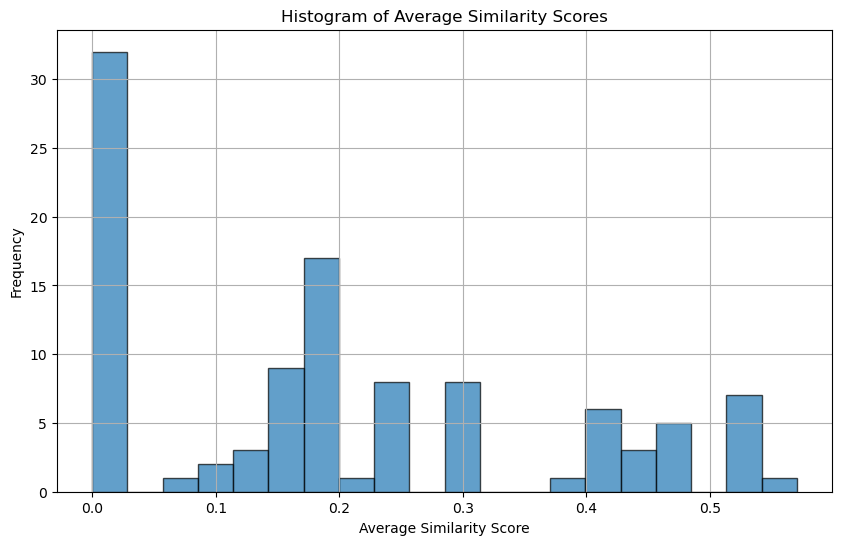

In [16]:
# Histogram of similarity scores
scores = df["similarity_tfidf"]
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, edgecolor="black", alpha=0.7)
plt.title("Histogram of Average Similarity Scores")
plt.xlabel("Average Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Filtration and Cutoff
- Per our Introduction, one of our success metrics was to **Rank candidates based on a fitness score**. This has been accomplished above.
- Our bonus objectives were to (1) Filter out candidates which in the first place should not be in this list and (2) Determine a cut-off point that would work for other roles without losing high potential candidates.
- We can accomplish both by setting a **threshold** that will eliminate the poorest performers in terms of similarity without trimming the dataset by too large a margin.
    - Visual inspection of the histogram suggests a cut off of **0.1**.

In [17]:
p = sum(df["similarity_tfidf"] > 0.1)/df.shape[0]
display(p, 1-p)

barrier()

p = sum(df["similarity_tfidf"] > 0)/df.shape[0]
display(p, 1-p)

0.6730769230769231

0.32692307692307687


 <<< -------------------------------------------------- >>> 



0.6923076923076923

0.3076923076923077

**NOTE:**
- An estimated **67.3%** of values are greater than the visually inspected **0.1** threshold while **69.2%** of values are greater than the **0** threshold.
- The degree or percentage of acceptable loss when it comes to filtering the values based on this similarity method would depend on the other methods, the potential for more data collection and further conversations with the client.

### Word embedding approach

In [18]:
model_w2v = api.load("word2vec-google-news-300")

In [19]:
def vectorize_job_title(job_title, model_w2v):
    word_vectors = [model_w2v[word] for word in job_title if word in model_w2v]
    if not word_vectors:
        return np.zeros(model_w2v.vector_size)
    return np.mean(word_vectors, axis=0)

def vectorize_phrase(phrase, model_w2v):
    words = clean_partial(phrase)
    word_vectors = [model_w2v[word] for word in words if word in model_w2v]
    if len(word_vectors) == 0:
        return np.zeros(model_w2v.vector_size)
    return np.mean(word_vectors, axis=0)

job_titles = df["job_title"]
job_title_vectors = np.array([vectorize_job_title(title, model_w2v) for title in job_titles])
keyphrases_vector = np.array([vectorize_phrase(keyphrase, model_w2v) for keyphrase in keyphrases])

all_similarity_scores = []

for keyphrase_vector in keyphrases_vector:
    keyphrase_vector_reshaped = keyphrase_vector.reshape(1, -1)
    similarity_scores = cosine_similarity(job_title_vectors, keyphrase_vector_reshaped)
    all_similarity_scores.append(similarity_scores.flatten())

all_similarity_scores = np.array(all_similarity_scores)
similarity_w2v = np.mean(all_similarity_scores, axis=0)

df["similarity_w2v"] = similarity_w2v
df.sort_values(by="similarity_w2v", ascending=False).head(20)

,job_title,similarity_tfidf,similarity_w2v
id,,,
73,aspiring human resources manager seeking internship human resources,0.570508,0.991507
99,seeking human resources position,0.437081,0.987770
28,seeking human resources opportunities,0.451102,0.987006
30,seeking human resources opportunities,0.451102,0.987006
78,human resources generalist schwan 's,0.199152,0.986023
62,seeking human resources human resources information system generalist positions,0.414564,0.985629
53,seeking human resources human resources information system generalist positions,0.414564,0.985629
40,seeking human resources human resources information system generalist positions,0.414564,0.985629
10,seeking human resources human resources information system generalist positions,0.414564,0.985629


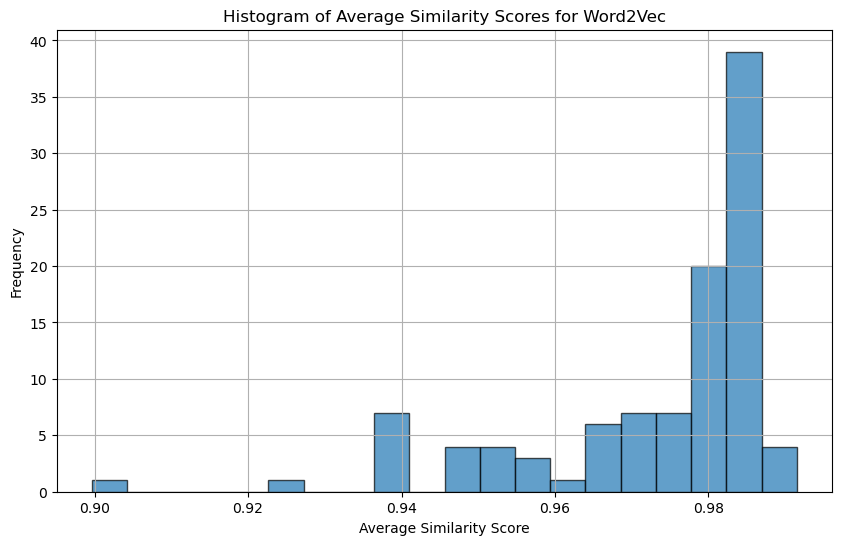

In [20]:
# Histogram of similarity scores
scores = df["similarity_w2v"]
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, edgecolor="black", alpha=0.7)
plt.title("Histogram of Average Similarity Scores for Word2Vec")
plt.xlabel("Average Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Filtration and Cutoff
- Per our Introduction, one of our success metrics was to **Rank candidates based on a fitness score**. This has been accomplished above.
- Our bonus objectives were to (1) Filter out candidates which in the first place should not be in this list and (2) Determine a cut-off point that would work for other roles without losing high potential candidates?
- We can accomplish both by setting a **threshold** that will eliminate the poorest performers in terms of similarity without trimming the dataset by too large a margin.
    - Visual inspection of the histogram suggests a cut off of **0.94**.

In [21]:
p = sum(df["similarity_w2v"] > 0.94)/df.shape[0]
display(p, 1-p)

0.9134615384615384

0.08653846153846156

**NOTE:**
- An estimated **91.3%** of values are greater than the visually inspected **0.94** threshold.
- The degree or percentage of acceptable loss when it comes to filtering the values based on this similarity method would depend on the other methods, the potential for more data collection and further conversations with the client.

### Sentence transformers approach

In [22]:
model_st = SentenceTransformer("all-MiniLM-L6-v2")

In [23]:
job_titles = df["job_title"].tolist()
job_title_embeddings = model_st.encode(job_titles, convert_to_tensor=True)
keyphrase_embeddings = model_st.encode(keyphrases, convert_to_tensor=True)
similarity_scores = util.pytorch_cos_sim(job_title_embeddings, keyphrase_embeddings)
df["similarity_st"] = similarity_scores.mean(axis=1)
df.sort_values(by="similarity_st", ascending=False).head(20)

,job_title,similarity_tfidf,similarity_w2v,similarity_st
id,,,,
3,aspiring human resources professional,0.525441,0.983309,0.861254
33,aspiring human resources professional,0.525441,0.983309,0.861254
21,aspiring human resources professional,0.525441,0.983309,0.861254
46,aspiring human resources professional,0.525441,0.983309,0.861254
58,aspiring human resources professional,0.525441,0.983309,0.861254
17,aspiring human resources professional,0.525441,0.983309,0.861254
97,aspiring human resources professional,0.525441,0.983309,0.861254
99,seeking human resources position,0.437081,0.987770,0.856455
49,aspiring human resources specialist,0.468502,0.981160,0.854354


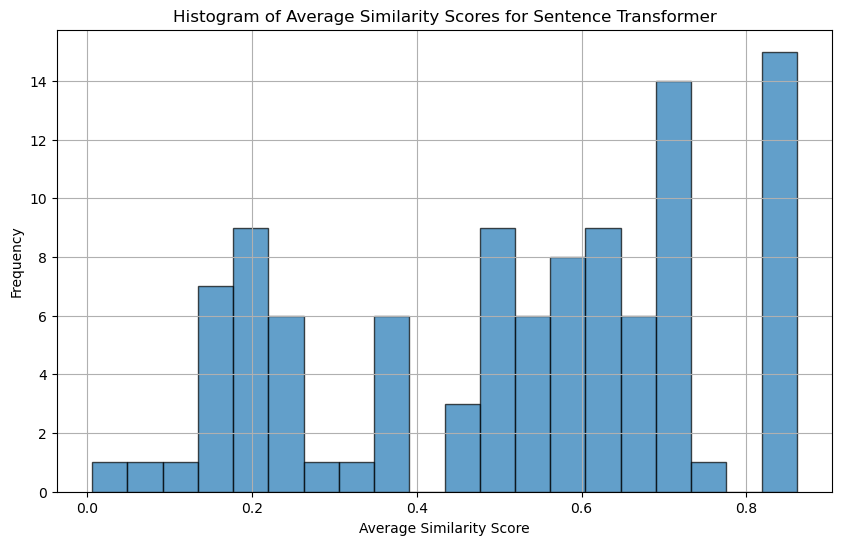

In [24]:
# Histogram of similarity scores
scores = df["similarity_st"]
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, edgecolor="black", alpha=0.7)
plt.title("Histogram of Average Similarity Scores for Sentence Transformer")
plt.xlabel("Average Similarity Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#### Filtration and Cutoff
- Per our Introduction, one of our success metrics was to **Rank candidates based on a fitness score**. This has been accomplished above.
- Our bonus objectives were to (1) Filter out candidates which in the first place should not be in this list and (2) Determine a cut-off point that would work for other roles without losing high potential candidates.
- We can accomplish both by setting a **threshold** that will eliminate the poorest performers in terms of similarity without trimming the dataset by too large a margin.
    - Visual inspection of the histogram suggests a cut off of **0.4** or **0.2**.

In [25]:
p = sum(df["similarity_st"] > 0.4)/df.shape[0]
display(p, 1-p)

barrier()

p = sum(df["similarity_st"] > 0.2)/df.shape[0]
display(p, 1-p)

0.6826923076923077

0.3173076923076923


 <<< -------------------------------------------------- >>> 



0.875

0.125

**NOTE:**
- An estimated **68.2%** of values are greater than the visually inspected **0.4** threshold while **87.5%** of values are greater than the **0.2** threshold.
- The degree or percentage of acceptable loss when it comes to filtering the values based on this similarity method would depend on the other methods, the potential for more data collection and further conversations with the client.

## Comparison of methods

In [26]:
keyphrases

['aspiring human resources', 'seeking human resources']

In [27]:
# Compare all methods
print_bold("Tfidf:")
display(df.sort_values(by="similarity_tfidf", ascending=False).head(10))
barrier()
print_bold("Word to vec:")
display(df.sort_values(by="similarity_w2v", ascending=False).head(10))
barrier()
print_bold("Sentence transformer:")
display(df.sort_values(by="similarity_st", ascending=False).head(10))

Tfidf:


,job_title,similarity_tfidf,similarity_w2v,similarity_st
id,,,,
73,aspiring human resources manager seeking internship human resources,0.570508,0.991507,0.728852
21,aspiring human resources professional,0.525441,0.983309,0.861254
3,aspiring human resources professional,0.525441,0.983309,0.861254
46,aspiring human resources professional,0.525441,0.983309,0.861254
58,aspiring human resources professional,0.525441,0.983309,0.861254
17,aspiring human resources professional,0.525441,0.983309,0.861254
97,aspiring human resources professional,0.525441,0.983309,0.861254
33,aspiring human resources professional,0.525441,0.983309,0.861254
24,aspiring human resources specialist,0.468502,0.981160,0.854354



 <<< -------------------------------------------------- >>> 

Word to vec:


,job_title,similarity_tfidf,similarity_w2v,similarity_st
id,,,,
73,aspiring human resources manager seeking internship human resources,0.570508,0.991507,0.728852
99,seeking human resources position,0.437081,0.987770,0.856455
28,seeking human resources opportunities,0.451102,0.987006,0.849407
30,seeking human resources opportunities,0.451102,0.987006,0.849407
78,human resources generalist schwan 's,0.199152,0.986023,0.640329
62,seeking human resources human resources information system generalist positions,0.414564,0.985629,0.701993
53,seeking human resources human resources information system generalist positions,0.414564,0.985629,0.701993
40,seeking human resources human resources information system generalist positions,0.414564,0.985629,0.701993
10,seeking human resources human resources information system generalist positions,0.414564,0.985629,0.701993



 <<< -------------------------------------------------- >>> 

Sentence transformer:


,job_title,similarity_tfidf,similarity_w2v,similarity_st
id,,,,
3,aspiring human resources professional,0.525441,0.983309,0.861254
33,aspiring human resources professional,0.525441,0.983309,0.861254
21,aspiring human resources professional,0.525441,0.983309,0.861254
46,aspiring human resources professional,0.525441,0.983309,0.861254
58,aspiring human resources professional,0.525441,0.983309,0.861254
17,aspiring human resources professional,0.525441,0.983309,0.861254
97,aspiring human resources professional,0.525441,0.983309,0.861254
99,seeking human resources position,0.437081,0.987770,0.856455
49,aspiring human resources specialist,0.468502,0.981160,0.854354


**NOTE:**
- Each model produces a different set of outcomes for the top 10 highest similarity job titles.

## Re-ranking based on starred id
- We can re-rank all candidates based on the id of an existing candidate.
- This would satisfy one of the success metrics which was to **Re-rank candidates when a candidate is starred**.
- This would be in the case where an existing candidate is manually identified as a **well matching** or **strong** candidate by which to compare all other candidates.
- We can use any of the three approaches above to accomplish this.
- For each method, we will select the median ranked candidate (the 53rd ranked candidate by each method), star them multiple times and see how their rank changes with each successive starring.
- **Note that**, in practice/production, we would not be able to star an id/candidate multiple times but, to demonstrate the gradual increase in rank (improvement in ranking with starring), we do so here.
- **Note also that**, the starring process changes the `df` and the `keyphrases` list so we will create a `reset` function that returns them to the state they were in prior to starring.
    - Again, in practice/production we would not do this but we want to maintain data integrity within this notebook.

In [28]:
# Copy df and keyphrases
df_no_rerank = df.copy()
keyphrases_no_rerank = [i for i in keyphrases]

# Reset df and keyphrases
def reset():
    df = df_no_rerank.copy()
    keyphrases = ["aspiring human resources", "seeking human resource"]
    return df, keyphrases

# Get rank according to a df that has been sorted by a given method
def get_rank(df_temp, id_temp):
    rank = df_temp.index.get_loc(id_temp) + 1
    return rank

### Tfidf

In [29]:
# Note that id_temp is the id to be starred
def star_tfidf(id_temp):
    keyphrases.append(df.loc[id_temp]["job_title"])
    keyphrases_vector = vectorizer.transform(keyphrases)
    similarity_scores = [cosine_similarity(X, keyphrase_vector) for keyphrase_vector in keyphrases_vector]
    similarity_tfidf = np.mean(similarity_scores, axis=0)
    df["similarity_tfidf"] = similarity_tfidf
    df_sorted = df.sort_values(by="similarity_tfidf", ascending=False)
    return df_sorted

In [30]:
# When you have 104 values, the middle value is the 53rd value which would have a python index of 52
middle_index = df.sort_values(by="similarity_tfidf", ascending=False).index[52]
middle_job_title = df.loc[middle_index].job_title
print(bold("Row:"), df.loc[middle_index], sep="\n")
barrier()
df_temp = df.sort_values(by="similarity_tfidf", ascending=False)
print_bold("Initial rank:")
print_bold(get_rank(df_temp, middle_index))
barrier()
print_bold("New ranks:")

for i in range(15):
    df_sorted = star_tfidf(middle_index)
    print(get_rank(df_sorted, middle_index))

df, keyphrases = reset()

Row:
job_title           2019 ct bauer college business graduate magna cum laude aspiring human resources professional
similarity_tfidf    0.177935                                                                                     
similarity_w2v      0.982241                                                                                     
similarity_st       0.501571                                                                                     
Name: 19, dtype: object

 <<< -------------------------------------------------- >>> 

Initial rank:
53

 <<< -------------------------------------------------- >>> 

New ranks:
11
3
3
3
3
5
5
5
5
5
5
5
7
7
7


### Word embedding

In [31]:
# Note that id_temp is the id to be starred
def star_w2v(id_temp):
    keyphrases.append(df.loc[id_temp]["job_title"])
    job_titles = df["job_title"]
    job_title_vectors = np.array([vectorize_job_title(title, model_w2v) for title in job_titles])
    keyphrases_vector = np.array([vectorize_phrase(keyphrase, model_w2v) for keyphrase in keyphrases])
    all_similarity_scores = []
    for keyphrase_vector in keyphrases_vector:
        keyphrase_vector_reshaped = keyphrase_vector.reshape(1, -1)
        similarity_scores = cosine_similarity(job_title_vectors, keyphrase_vector_reshaped)
        all_similarity_scores.append(similarity_scores.flatten())
    all_similarity_scores = np.array(all_similarity_scores)
    similarity_w2v = np.mean(all_similarity_scores, axis=0)
    df["similarity_w2v"] = similarity_w2v
    sorted_df = df.sort_values(by="similarity_w2v", ascending=False)
    return sorted_df

In [32]:
middle_index = df.sort_values(by="similarity_w2v", ascending=False).index[52]
middle_job_title = df.loc[middle_index].job_title
print(bold("Row:"), df.loc[middle_index], sep="\n")
df_temp = df.sort_values(by="similarity_w2v", ascending=False)
barrier()
print_bold("Initial rank:")
print_bold(get_rank(df_temp, middle_index))
barrier()

print_bold("New ranks:")
for i in range(15):
    df_sorted = star_w2v(middle_index)
    print(get_rank(df_sorted, middle_index))

df, keyphrases = reset()

Row:
job_title           aspiring human resources specialist
similarity_tfidf    0.468502                           
similarity_w2v      0.98116                            
similarity_st       0.854354                           
Name: 60, dtype: object

 <<< -------------------------------------------------- >>> 

Initial rank:
53

 <<< -------------------------------------------------- >>> 

New ranks:
14
2
2
1
2
3
3
4
4
4
4
4
4
4
4


### Sentence transformers

In [33]:
# Note that id_temp is the id to be starred
def star_st(id_temp):
    keyphrases.append(df.loc[id_temp]["job_title"])
    job_titles = df["job_title"].tolist()
    job_title_embeddings = model_st.encode(job_titles, convert_to_tensor=True)
    keyphrase_embeddings = model_st.encode(keyphrases, convert_to_tensor=True)
    similarity_scores = util.pytorch_cos_sim(job_title_embeddings, keyphrase_embeddings)
    df["similarity_st"] = similarity_scores.mean(axis=1)
    sorted_df = df.sort_values(by="similarity_st", ascending=False)
    return sorted_df

In [34]:
middle_index = df.sort_values(by="similarity_st", ascending=False).index[52]
middle_job_title = df.loc[middle_index].job_title
print(bold("Row:"), df.loc[middle_index], sep="\n")
df_temp = df.sort_values(by="similarity_st", ascending=False)
barrier()
print_bold("Initial rank:")
print_bold(get_rank(df_temp, middle_index))
barrier()

print_bold("New ranks:")
for i in range(15):
    df_sorted = star_st(middle_index)
    print(get_rank(df_sorted, middle_index))

df, keyphrases = reset()

Row:
job_title           human resources coordinator intercontinental buckhead atlanta
similarity_tfidf    0.152223                                                     
similarity_w2v      0.965675                                                     
similarity_st       0.567854                                                     
Name: 56, dtype: object

 <<< -------------------------------------------------- >>> 

Initial rank:
53

 <<< -------------------------------------------------- >>> 

New ranks:
18
3
4
2
3
2
3
2
2
2
1
1
1
1
1


**NOTE:**
- In each case, the rank rises significantly from its original value the more we star a given id.
- This satisfies one of our goals which is to **Re-rank candidates when a candidate is starred**.
- **Note also** that, while all ranks improved from their initial value, the rank value may still demonstrate small fluctuations in the event of samples whose job titles are duplicated within the dataset.
    - In this case, though we sort in descending order of similarity, since multiple samples can have the same job title, they can also have the same similarity which could lead to small discrepancies in their successive rankings.

## Web app for demonstration
**NOTE:**
- This web app is built with gradio.
- Unlike the starring functions above which uses `id`, this app re-ranks the candidates based on entered keyphrases/job titles and not the original given keyphrases (“Aspiring human resources” or “seeking human resources”).
- This satisfies two of our bonus goals which were to (1) **Determine a cut-off point that would work for other roles without losing high potential candidates** and (2) **Automate this procedure to prevent human bias**.
    - It does so by allowing the user to enter the keywords they're looking for without access tot he behind-the-scenes algorithms or user metadata (in this case, the `id`, `location` or `connections` features).

**NOTE:**
- To use the app, simply type in keywords **separated by commas** and hit submit to get results.
- For demonstration, we used the **Sentence transformer** method to calculate similarity and rerank candidates.
    - This was selected arbitrarily. In production, any number of other methods (including methods not shown in this notebook) can be used.

In [35]:
# App function
def rank_job_titles(kps):
    kps_list = kps.split(",")
    kps_list = [kp.strip() for kp in kps_list]
    job_title_embeddings = model_st.encode(job_titles, convert_to_tensor=True)
    kp_embeddings = model_st.encode(kps_list, convert_to_tensor=True)
    similarity_scores = util.pytorch_cos_sim(job_title_embeddings, kp_embeddings)
    df["similarity_st"] = similarity_scores.mean(axis=1)
    sorted_df = df.sort_values(by="similarity_st", ascending=False)
    return sorted_df[["job_title"]]

# Gradio interface
placeholder = "Enter keyphrases separated by commas: "
iface = gr.Interface(fn=rank_job_titles, inputs=gr.Textbox(placeholder=placeholder), outputs=gr.Dataframe())

# Launch interface
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7864

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


## Final conclusion & inference

**Scope & Objective/Goals:**
- See [Introduction](#Introduction).

**Data Wrangling & Exploratory Data Analysis:**
- The data contains 104 samples in total.
- The data contained 51 duplicated rows.
- The data contained no missing values.

**Preprocessing and Training:**
- The data was cleaned using Natural Language techniques such as lowercasing, deaccenting, abbreviation substitution, stemming, lemmatization, special character removal and stopword removal.
- Unhelpful features were dropped.

**Modeling:**
- We used three different approaches for text encoding the job titles into vectors.
- We used cosine similarities to calculate the average similarities between all candidate job titles and each of our keyphrases.
    - This provided us with rankings for each candidate.
- We learned to update our calculations and subsequent rankings by starring candidates or by providing new keyphrases.
- We used gradio to create a browser-based app to automate the process and minimize human bias.

**Further Steps to consider:**
- We can consider other encoding steps.
- We can consider the use of LLMs and Prompting.
- We can consider using ranking libraries like Ranknet.